# Spring 2020 CX4641/CS7641 Homework 3

## Instructor: Dr. Mahdi Roozbahani

## Deadline: Apr 2nd, 11:59 pm

* No unapproved extension of the deadline is allowed. Late submission will lead to 0 credit. 

* Homework submission ONLY in .ipynb format.

## Instructions for the assignment

- The Q5 is bonus for both undergraduate and graduate students.

- To switch between cell for code and for markdown, see the menu -> Cell -> Cell Type
    
- You could directly type the Latex equations in the markdown cell.

- Typing with Latex\markdown is required for all the written questions. Handwritten answers would not be accepted. 
    
- If a question requires a picture, you could use this syntax $"<img src="" style="width: 300px;"/>"$ to include them within your ipython notebook.

## Programming (100pts)

## 1 Principal Component Analysis [20pts]


### Environment Setup

In [1]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer, load_iris, load_wine
%matplotlib inline

## Load images data and plot
We load the dataset we will deal with, and show the image

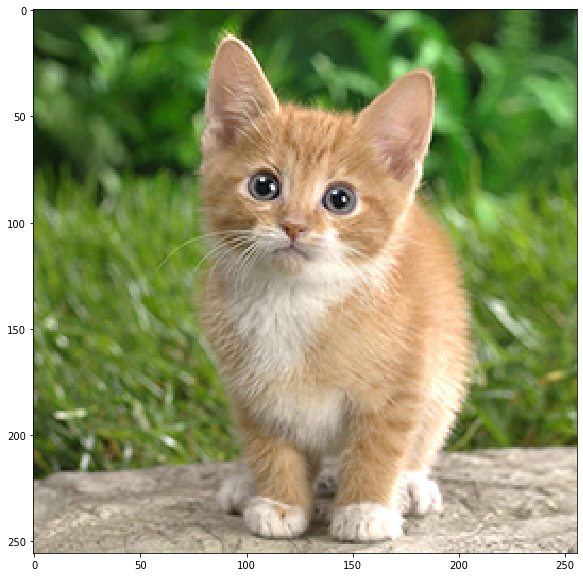

In [6]:
image = plt.imread("hw_3_img.jpg")/255.
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

We can transfer the image to grayscale as follows:

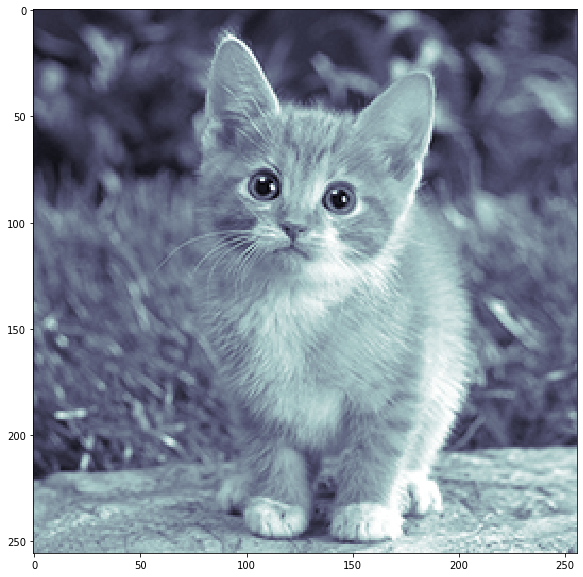

In [7]:
def rgb2gray(rgb):   
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig = plt.figure(figsize=(10, 10))
# plot several images
plt.imshow(rgb2gray(image), cmap=plt.cm.bone)

### Image compression

The SVD allows us to compress an image by throwing away the least important information.  The higher the singular values -> the higher the variance -> most information from the corresponding singular vector.

Use numpy to calculate SVD for each image matrix(R,G and B for a color image) and get rid of the small singular values to compress the image. The loss of information is negligible as the difference is very difficult to be spotted. 

[Principal Component Analysis](https://mahdi-roozbahani.github.io/CS46417641-spring2020/course/12-dimension-reduction.pdf)(PCA) follows the same process to elimate the small variance eigenvalues and their vectors.  With PCA, we center the data first by subtracting the mean.

Each singular value tells us how much of the variance of a matrix (e.g. image) is captured in each component.  For example, the variance captured by the first component is $$\frac{\sigma_1^2}{\sum_{i=1}^n \sigma_i^2}$$ where $\sigma_i$ is the $i^{th}$ singular value.

There is no need to standardize the images for image compression task because the objective of the task is to rebuild back the original images with the compressed information.

You need to finish the following functions to do SVD and then reconstruct the image by components.

In [80]:
def svd(X):
    """
    Do SVD. You could use numpy SVD. 
    Your function should be able to handle black and white 
    images (N*D arrays) as well as color images (N*D*3 arrays)

    In the image compression, we assume that each coloum of the image is a feature. Image is the matrix X.
    
    Args: 
        X: N * D array corresponding to an image (N*D*3 if color image)
    Return:
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)
    """
    
    if len(X.shape) == 2:
        U,S,V = np.linalg.svd(X)
        return U,S,V
    else:
        N,D,K = X.shape
        U = np.zeros(shape=(N,N,K))
        S = np.zeros(shape = (min(N,D),K))
        V = np.zeros(shape=(D,D,K))
        for i in range(K):
            U[:,:,i],S[:,i],V[:,:,i] = svd(X[:,:,i])
        return U,S,V
    
def rebuildsvd(U, S, V, k):
    """
    Rebuild SVD by k componments.
    Args: 
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)  
        k: int corresponding to number of components
    Return:
        Xrebuild: N*D array of reconstructed image (N*D*3 if color image)
        
    Hint: numpy.matmul may be helpful for reconstructing color images
    """
    if len(U.shape) == 2:
        U_new = U[:,:k]
        S_new = S[0:k]
        V_new = V[:k,]
        Xrebuild = np.matmul(U_new,np.matmul(np.diag(S_new),V_new))
        #print("rebuild: ", Xrebuild.shape)
    else:
        Xrebuild = np.zeros((U.shape[0],V.shape[0],3))
 
        U_new= U[:,:k,:]
        S_new = S[0:k,:]
        V_new = V[:k,:,:]
        for i in range(3):
            Xrebuild[:,:,i] = np.matmul(U_new[:,:,i],np.matmul(np.diag(S_new[:,i]),V_new[:,:,i]))   
    return Xrebuild
    

def compression_ratio(X, k):
    """
    Compute compression of an image: (num stored values in compressed)/(num stored values in original)
    Args: 
        X: N * D array corresponding to an image (N * D * 3 if color image)
        k: int corresponding to number of components
    Return:
        compression_ratio: float of proportion of storage used by compressed image
    """
    
    if len(X.shape)==2:
        N,D = X.shape
        compression_ratio = (k*N+k*D+k)/(N*D)
    else:
        N,D,K = X.shape
        compression_ratio = (k*(N*3)+k*(D*3)+k*3)/(N*D*K)
    return compression_ratio

def recovered_variance_proportion(S, k):
    """
    Compute the proportion of the variance in the original matrix recovered by a rank-k approximation
    
    Args:
       S: min(N, D)*1 (*3 for color images) of singular values for the image
       k: int, rank of approximation
    Return:
       recovered_var: int (array of 3 ints for color image) corresponding to proportion of recovered variance
    """
    S = S**2
    if len(S.shape) == 1:
        diag_sum = np.sum(np.diag(S[:k]))
        total_sum = np.sum(np.diag(S))
        recovered_var = diag_sum/total_sum
    else:
        recovered_var = np.zeros(3)
        for i in range(3):
            diag_sum = np.sum(np.diag(S[:k,i]))
            total_sum = np.sum(np.diag(S[:,i]))
            recovered_var[i] = diag_sum/total_sum
    #print("recovered var:", recovered_var)
    return recovered_var

**Now let us see the results for image reconstruction.**  
1) Black and White

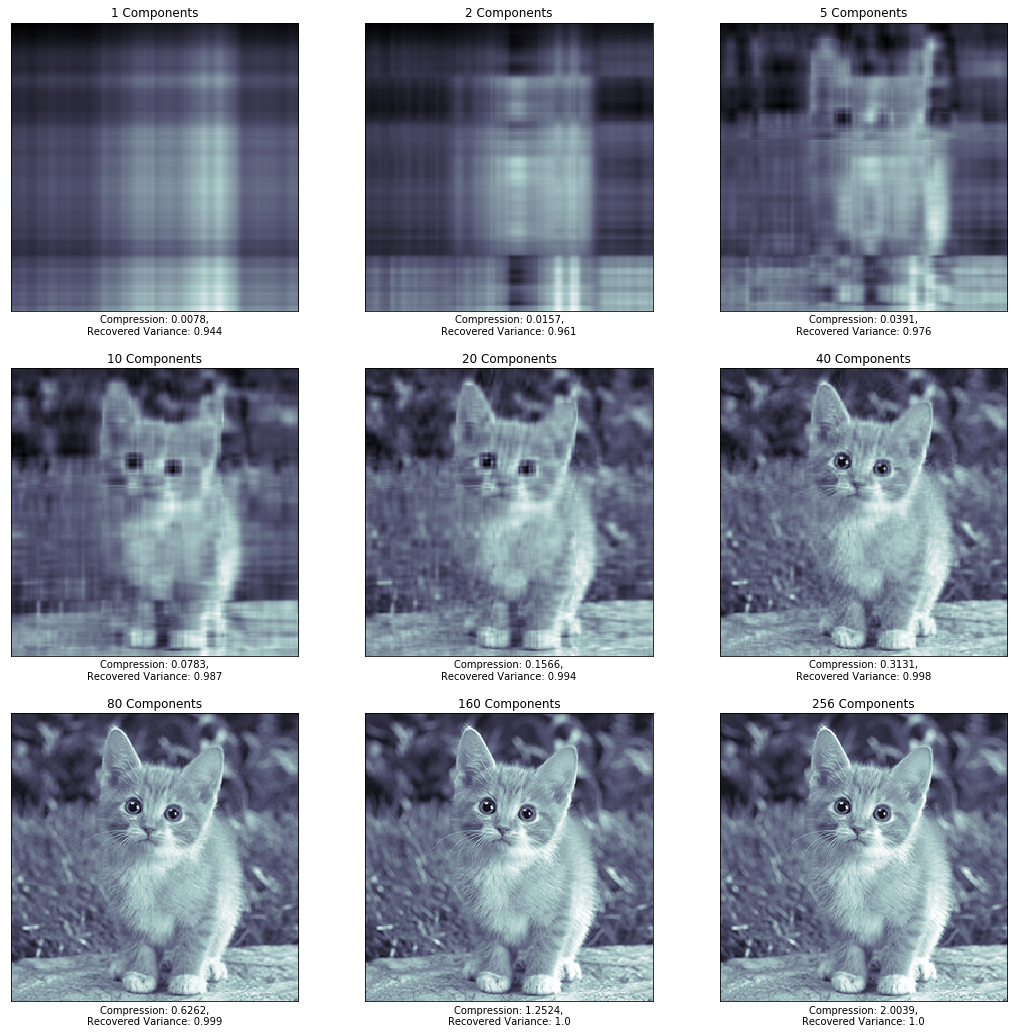

In [336]:
#helper do not need to change

bw_image = rgb2gray(image)
U, S, V = svd(bw_image)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(bw_image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1

2) Color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


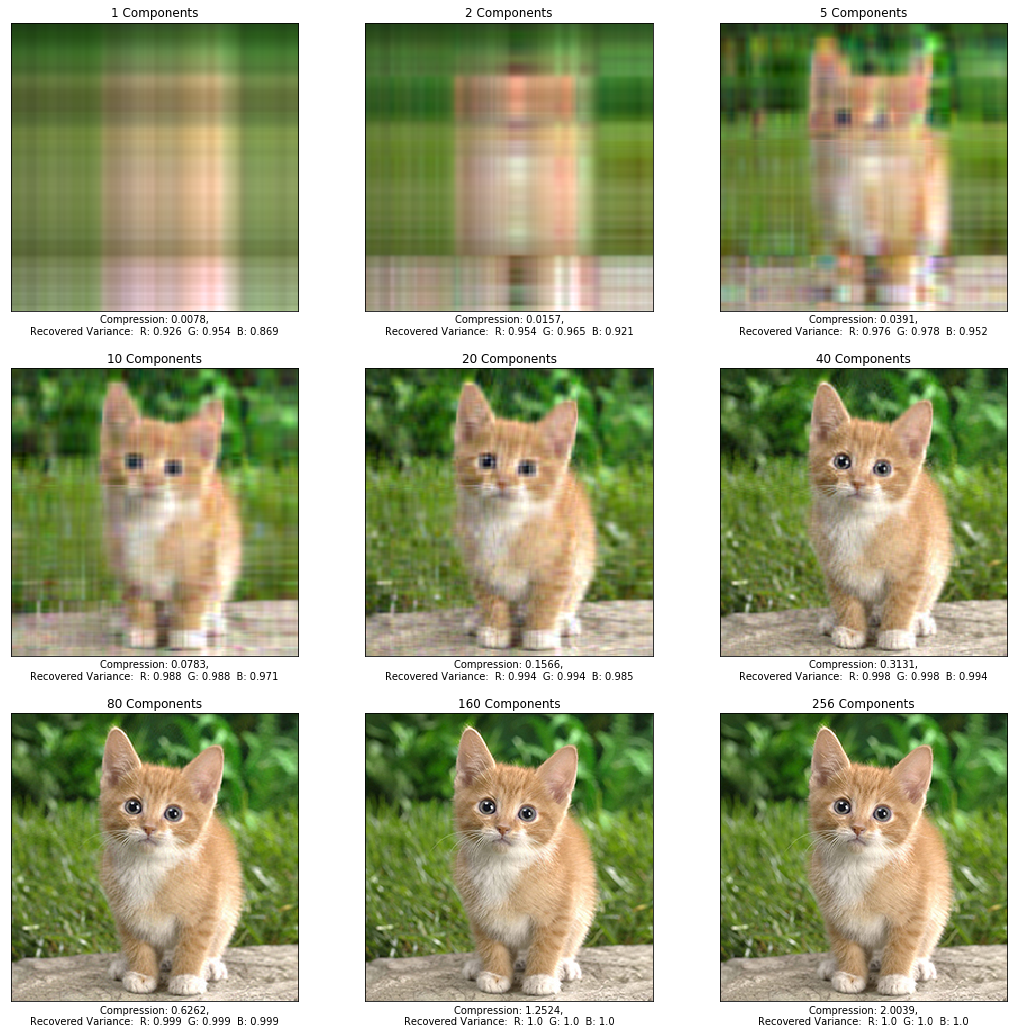

In [337]:
#helper do not need to change

U, S, V = svd(image)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

## 2 Polynomial Regression with Regularization [40pts]

#### 2.1 Helper functions [5pts]
1) RMSE [5pts] 

In [72]:
def rmse(pred, label): 
    '''
    This is the root mean square error.
    Args:
        pred: numpy array of length N * 1, the prediction of labels
        label: numpy array of length N * 1, the ground truth of labels
    Return:
        a float value
    '''
    rmse = np.sqrt(np.mean((pred - label) ** 2))
    return rmse


prediction = np.array([1, 2, 3]) 
label = np.array([1.5, 2.5, 3.5])
print('rmse =',rmse(prediction, label))

rmse = 0.5


Do you know whether this RMSE is good or not? If you don't know, we could normalize our labels between 0 and 1. After normalization, what does it mean when RMSE = 1? 

**Hint**: think of the way that you can enforce your RMSE = 1. Note that you can not change the actual labels to make RMSE = 1.

#### Answer

Assuming RMSE = 1 and $n$ points, we have
$$\sqrt{\frac{1}{n}\sum(prediction - label)^2} = 1$$
$$\sum(prediction - label)^2 = n$$
In this case, either prediction = 0 and label = 1 or prediction = 1 and label = 0, which predictions are all incorrect. Thus when RMSE closer to 0, the better prediction.

2) Construct polynomial features [5pts]

In [177]:
def construct_polynomial_feats(x, degree):
    """
    Args:
        x: numpy array of length N, the 1-D observations
        degree: the max polynomial degree
    Return:
        feat: numpy array of shape Nx(degree+1), remember to include 
        the bias term. feat is in the format of:
        [[1.0, x1, x1^2, x1^3, ....,],
         [1.0, x2, x2^2, x2^3, ....,],
         ......
        ]
    """
    feat = []
    N = len(x)
    for j in range(N):
        r = []
        for i in range(1,degree+1):
            r.append(np.power(x[j],i))
        #print(r)
        r = [1] + r
        #print(r,"\n")
        feat.append(r)
            
    return np.array(feat)  

# Here there are two data points. One data point is 0.5 and other one is 0.2. 
# We try to represent these two data points in higher dimensions.

x = np.array([0.5, 0.2]) 
x_feat = construct_polynomial_feats(x, 4)
print(x_feat)

[[1.     0.5    0.25   0.125  0.0625]
 [1.     0.2    0.04   0.008  0.0016]]


In [74]:
#helper do not need to change
def plot_curve(x, y, curve_type='.', color='b', lw=2):
    plt.plot(x, y, curve_type, color=color, linewidth=lw)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

#### 2.2 Linear Regression [20pts]

We have three methods to fit linear gression model: 1) close form; 2)Gradient descent (GD); 3) Stochastic gradient descent (SGD). Undergraduate students only need to implement one of them(10 pts bonus if you implement them all). Graduate students need to implement all of them.

After fitting the model, we need to implement the prediction function. [5pts]

In [87]:
class LinearReg(object):
    @staticmethod 
    # static method means that you can use this method or function for any other classes, it is not specific to LinearReg
    def fit_closed(xtrain, ytrain):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        xtx = xtrain.T@xtrain
        #print(xtx.shape)
        
        inv = np.linalg.inv(xtx)
        weight = (inv@xtrain.T)@ytrain
        return weight
        
    @staticmethod
    
    def fit_GD(xtrain, ytrain, epochs=5, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
         
        N,D = xtrain.shape
        weight = np.zeros((D,1))
        EPOCH = []
        RMSE = []
        
        for epoch in range(epochs):
            pred = np.dot(xtrain, weight)#Nx1
            diff = ytrain-pred #Nx1
            gradient = np.matmul(xtrain.T, diff)/N #Dx1
            weight += learning_rate*gradient
            
            EPOCH.append(epoch)
            rmse_ = rmse(np.matmul(xtrain, weight),ytrain)
            RMSE.append(rmse_)
            
        plt.plot(EPOCH,RMSE)
        plt.xlabel('epochs')
        plt.ylabel('rmse')
        return weight

    @staticmethod
    def fit_SGD(xtrain, ytrain, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        N,D = xtrain.shape
        weight = np.zeros((D,1))
        EPOCH = []
        RMSE = []
        
        for epoch in range(epochs):
            for n in range(N): #row
                pred = LinearReg.predict(xtrain[n], weight)#Nx1 - row
                diff = ytrain[n]-pred #Nx1
                for d in range(D): #col
                    gradient = diff*xtrain[n][d]
                    weight[d] += learning_rate*gradient
            EPOCH.append(epoch)
            rmse_ = rmse(np.matmul(xtrain, weight),ytrain)
            RMSE.append(rmse_)
        plt.plot(EPOCH,RMSE)
        plt.xlabel('epochs')
        plt.ylabel('rmse')
        return weight

    @staticmethod
    def predict(xtest, weight):
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: Dx1 numpy array, the weights of linear regression model
        Return:
            prediction: Nx1 numpy array, the predicted labels
        """
        prediction = xtest@weight
        return prediction
        
        
        
# Hint: in the fit function, use close form solution of the linear regression to get weights. 
# For inverse, you can use numpy linear algebra function  
# For the predict function, you need to use linear combination of data points and their weights (y = w0*1+w1*X1+...)

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5, where the groundtruth function is just a linear function (i.e., only require polynomial features up to degree 1).

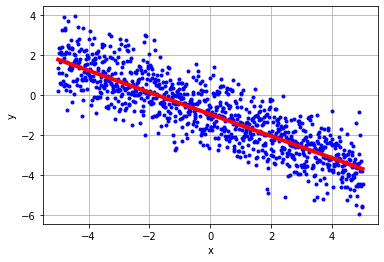

In [88]:
#helper, do not need to change

POLY_DEGREE = 5
NUM_OBS = 1000

rng = np.random.RandomState(seed=4)

true_weight = -rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
x_all = np.linspace(-5, 5, NUM_OBS)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) # in the second term, we add noise to data
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4) # the groundtruth information

indices = rng.permutation(NUM_OBS)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by $Y = X\theta + \sigma$, where $\sigma \sim \mathcal{N}(0, 1)$ are i.i.d. generated noise and $\theta$ represents the weights or the parameters of our model.

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

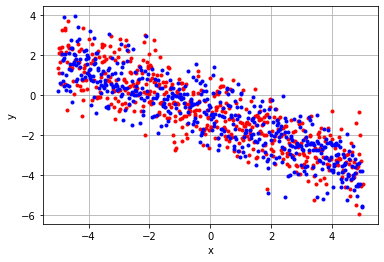

In [89]:
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

Now let's first train using the entire training set, and see how we perform on the test set and how the learned function looks like.

In [90]:
#Do not need to change

weight = LinearReg.fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=0.9222")

test rmse: 0.9222
correct answer=0.9222


test rmse: 1.1314
correct answer=1.1314


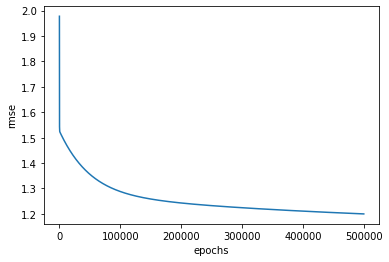

In [91]:
#Do not need to change

weight = LinearReg.fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=500000, learning_rate=1e-7)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=1.1314")

test rmse: 1.0974
correct answer=1.0974


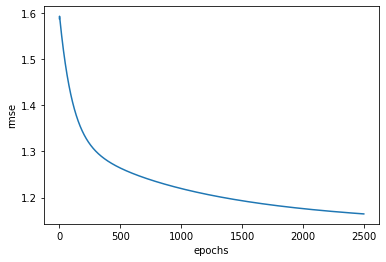

In [92]:
#Do not need to change

weight = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=2500, learning_rate=1e-7)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=1.0974")

And what if we just use the first 10 observations to train? 

In [93]:
#Do not need to change

sub_train = train_indices[:10]
weight = LinearReg.fit_closed(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=2.1910")

test rmse: 2.1910
correct answer=2.1910


Did you see a worse performance? Let's take a closer look at what we have learned.

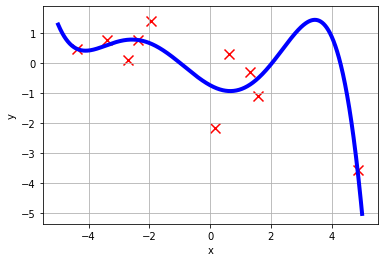

In [94]:
#Do not need to change
# x_all_feat was constructed by polynomial features of degree of 5

y_pred = LinearReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)

#### 2.3 Ridge Regression [10pts]

Now let's try ridge regression. We will call the prediction function from linear regression part.

In [95]:
class RidgeReg(LinearReg):

    @staticmethod
    def fit_closed(xtrain, ytrain, c_lambda):
        N,D = xtrain.shape
        weight = np.zeros((D,1))
        z = xtrain
        ID = np.identity(D)
        ID[0][0] = 0
        DxD = np.matmul(z.T,z) + c_lambda*ID
        inv = np.linalg.pinv(DxD)
        weight = np.matmul(np.matmul(inv,z.T),ytrain)
        
        return weight
    
    @staticmethod
    def fit_GD(xtrain, ytrain, c_lambda, epochs=500, learning_rate=1e-7):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        N,D = xtrain.shape
        weight = np.zeros((D,1))
        
        for epoch in range(epochs):
            pred = LinearReg.predict(xtrain, weight)
            loss = ytrain - pred
            regul = c_lambda*weight/N
            gradient = np.dot(xtrain.T,loss)/N+regul
            weight += learning_rate * gradient
            
        return weight

         
    
    @staticmethod
    def fit_SGD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
      
        N,D = xtrain.shape
        weight = np.zeros((D,1))
        
        for epoch in range(epochs):
            for n in range(N): #row
                pred = LinearReg.predict(xtrain[n], weight)#Nx1 - row
                diff = ytrain[n]-pred #Nx1
                for d in range(D): #col
                    gradient = diff*xtrain[n][d]
                    regul = c_lambda*weight[d]
                    weight[d] += learning_rate * (gradient-regul)
        return weight


Again, let's see what we have learned. You only need to run the cell corresponding to your specific implementation.

(10, 6)
(10, 1)
test rmse: 1.3589
correct answer=1.3589


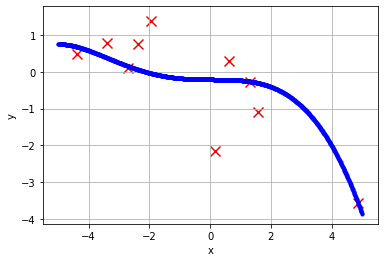

In [96]:
# You do not need to change the code here

sub_train = train_indices[:10]
print(x_all_feat[sub_train].shape)
print(y_all[sub_train].shape)
weight = RidgeReg.fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=1.3589")

test rmse: 1.5829
correct answer=1.5831


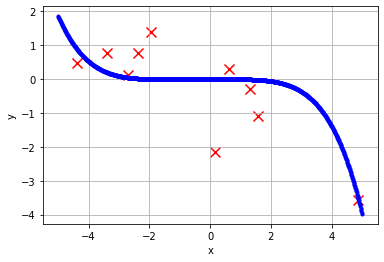

In [97]:
# You do not need to change the code here

sub_train = train_indices[:10]
weight = RidgeReg.fit_GD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=1.5831")

test rmse: 1.5901
correct answer=1.5893


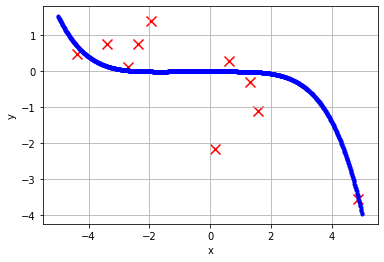

In [98]:
# You do not need to change the code here

sub_train = train_indices[:10]
weight = RidgeReg.fit_SGD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print("correct answer=1.5893")

#### 2.4 Cross Validation [5pts]
Let's use Cross Validation to find the best value for c_lambda. 

In [99]:
# We provided 6 possible values for lambda, and you will use them in cross validation.
# For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
# For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
# At the end for each lambda, you have caluclated 10 rmse and get the mean value of that.
# That's it. Pick up the lambda with the lowest mean value of rmse. 
# Hint: np.concatenate is your friend.

def cross_validation(X, y, kfold, c_lambda):
    X_split = np.array_split(X, kfold)
    y_split = np.array_split(y, kfold)
    RMSE = []
    
    for i in range(kfold):
        train_data = np.concatenate(X_split[:i] + X_split[i+1:])
        test_data = X_split[i]
        train_label = np.concatenate(y_split[:i] + y_split[i+1:])
        test_label = y_split[i]
        weight = RidgeReg.fit_closed(train_data, train_label, c_lambda)
        pred_label = RidgeReg.predict(test_data, weight)
        rmse_ = rmse(pred_label, test_label)
        RMSE.append(rmse_)
    
    result = np.mean(np.array(RMSE))
    return result
   
    

best_lambda = None
best_error = None
kfold = 10
lambda_list = [0, 0.1, 1, 5, 10, 100, 1000]
for lm in lambda_list:
    err = cross_validation(x_all_feat[train_indices], y_all[train_indices], kfold, lm)
    print('lambda: %.2f' % lm, 'error: %.6f'% err)
    if best_error is None or err < best_error:
        best_error = err
        best_lambda = lm

print('best_lambda: %.2f' % best_lambda)
weight = RidgeReg.fit_closed(x_all_feat[train_indices], y_all[train_indices], c_lambda=10)
y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

lambda: 0.00 error: 0.999078
lambda: 0.10 error: 0.999079
lambda: 1.00 error: 0.999083
lambda: 5.00 error: 0.999139
lambda: 10.00 error: 0.999290
lambda: 100.00 error: 1.008501
lambda: 1000.00 error: 1.056372
best_lambda: 0.00
test rmse: 0.9219


lambda: 0.00 error: 0.999078<br/>
lambda: 0.10 error: 0.999079<br/>
lambda: 1.00 error: 0.999083<br/>
lambda: 5.00 error: 0.999139<br/>
lambda: 10.00 error: 0.999290<br/>
lambda: 100.00 error: 1.008501<br/>
lambda: 1000.00 error: 1.056372<br/>
best_lambda: 0.00<br/>
test rmse: 0.9219

## 3 Lasso Regression [Bonus for Undergraduate][20pts]

During the class, we have discussed how to solve for the weight $\theta$ for ridge regression and we now want you to solve for the lasso regression. Unlike ridge regression, the Lasso regression does not have a close form solution and we will be doing it by coordinate descent. That is, we will be updating $\theta$ not as a whole but update $\theta_1$ first then update $\theta_2, \dots, \theta_d$. Now, you will be deriving the steps for the coordinate descent. Consider a sample consisting of N cases, each of which consists of d features and a single outcome. Let ${\displaystyle y_{i}}$ be the outcome and ${\displaystyle x_{i}:=(x_{1},x_{2},\ldots ,x_{d})^{T}}$be the features vector for the $i^{th}$ case.The objective function looks like this:
$$
{\underset {\theta\in\mathbb{R}}{\operatorname {min} }}\{\frac{1}{N}\parallel y-X\theta \parallel^2_2 + \frac{\lambda}{N} \parallel \theta\parallel_1\}
$$
Here, you are asked to compute the weights $\theta$ for the lasso regression.

#### 3.1 Write out the lagrangian in terms of vector and matrix entries $x_{ij}$, $y_i$ and $\theta_i$ using the matrix multiplication formula and definition of the norm. (hint: the above objective function is in matrix form, but this question is asking you to write the objective function in summation form for each entry.)
$$L(\theta) = {\underset {\theta\in\mathbb{R}}{\operatorname {min} }}\{\frac{1}{N}\bigg(\sum_{i=1}^{N}(y_i-\sum_{j=1}^{D}x_{ij}\theta_j)^2\bigg)+\frac{\lambda}{N}\sum_{j=1}^{D}|\theta_j|\}$$

#### 3.2 We now define $p_k=\sum_{i=1}^n(x_{ik}(y_i-\sum_{j=1,j\neq{k}}^dx_{ij}\theta_j)$ and $z_k=\sum_{i=1}^nx_{ik}^2$. Use $p_k$ and $z_k$ to represent the derivative of the first term in the Lagrangian and derive the update rule for $\theta$.
First, consider the mean sqaured error part,
$$ \frac{\partial L(\theta)}{\partial \theta_j} = \frac{1}{n}\left(\sum_{i=1}^{n} 2(y_{i} - \sum_{j=1}^{d}x_{ij}\theta_j)(-x_{ik})\right) $$
$$\sum_{j=1}^{d}x_{ij}\theta_j = \left(\sum_{j=1,j\neq{k}}^n \theta_j \cdot x_{ij}\right) + \theta_kx_{ik} $$
then

$$ \frac{\partial L(\theta)}{\partial \theta_j} = \frac{2}{N}\bigg(\sum_{i=1}^{n} (-x_{ik})(y_{i} - \bigg(\sum_{j=1,j\neq{k}}^{d} \theta_j x_{ij}\bigg)\bigg) \bigg) + \frac{2}{N}\theta_{k}\bigg(\sum_{i=1}^{n} x_{ik} \bigg)^2 $$
taking$p_k$ and $z_k$, we have
$$ \frac{\partial L(\theta)}{\partial \theta_j}=\frac{-2}{N}p_k + \frac{2}{N}\theta_kz_k$$
Then taking the loss part
$$ \frac{\partial L(\theta)}{\partial \theta_j} =\frac{-2}{N}p_k + \frac{2}{N}\theta_kz_k + \frac{\lambda}{N}\frac{\partial|\theta_j|}{\partial\theta_j}$$
Set 
$$\frac{\partial L(\theta)}{\partial \theta_j} = 0$$
there are 3 cases to consider for loss:

1: $\theta_j < 0$
$$\frac{-1}{N}p_k + \frac{1}{N}\theta_jz_k - \frac{\lambda}{N} = 0$$

$$\theta_j = \frac{p_k + \lambda/2}{z_k}$$

For $\theta < 0$
$$p_k < -\lambda/2$$

2: $\theta_j$ = 0
$$\frac{-1}{N}p_k + \frac{1}{N}\theta_jz_k + [-\frac{\lambda}{N},\frac{\lambda}{N}] = 0$$

$$\theta_j = [\frac{p_k - \lambda/2}{z_k},\frac{p_k +  \lambda/2}{z_k}]$$

For $\theta_j$ = 0, need $[\frac{[p_k - \lambda/2}{z_k},\frac{p_k + \lambda/2}{z_k}]$ to be 0, then
$$-\lambda/2 ≤ p_k ≤ \lambda/2 $$

3:$\theta_j >0$
$$\frac{-1}{N}p_k + \frac{1}{N}\theta_jz_k + \frac{\lambda}{N} = 0$$

$$\theta_j = \frac{p_k - \lambda/2}{z_k}$$

For $\theta > 0$
$$p_k > \lambda/2$$

#### 3.3 Use the update rule you derived in 3.2 to implement the Lasso Regression class in the template below.

#### 3.4 Apply the Lasso Regression to the synthetic data and report the results.

In [155]:

class LassoReg(LinearReg):
    
    
    @staticmethod
    def fit(xtrain, ytrain,c_lambda,n_iter=100):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
            c_lambda: Scalar, the lambda value
            n_iter: Scalar, the number of iterations you will take to update your weight
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        N,D = xtrain.shape
        weight = np.zeros(D)
        #normalize
        z = np.sum(xtrain*xtrain,axis=0)
        #xtrain = xtrain / (np.linalg.norm(xtrain,axis = 0))
        
        iteration = 0
        while(iteration<n_iter):
            for k in range(D): 
                X_this = np.delete(xtrain,k,axis=1) #Remove k=j
                weight_this = np.delete(weight,k,axis = 0).reshape(-1,1) #Remove k=j
                
                #find p
                pred = X_this@weight_this
                diff = ytrain - pred
                p = xtrain[:, k]@diff
                
                #print("p:",p)
                
                if k == 0: #no regularization
                    weight[k] = p/(z[k])
                elif p< -c_lambda/2:
                    weight[k] = (p+c_lambda/2)/(z[k])
                elif p> c_lambda/2:
                    weight[k] =(p-c_lambda/2)/(z[k])
                else:
                    weight[k] = 0
            iteration += 1
                
            #print("weight",weight)
        
        return weight
    



You only need to complete the fit function with the closed form. n_iter is the number of iterations you will take to update your weight. 

test rmse: 2.2412
correct answer = 1.6277


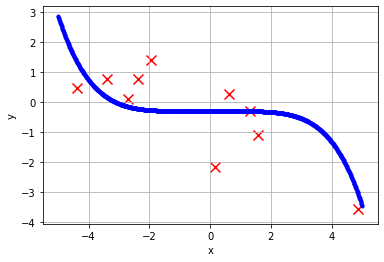

In [156]:
sub_train = train_indices[:10]
weight = LassoReg.fit(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)

y_pred = LassoReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = LassoReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)
print('correct answer = 1.6277')


## 4 PCA analysis [20 pts]

In this problem, we will investigate how PCA can be used to improve features for regression and classification tasks and how the data itself affects the behavior of PCA. Implement PCA in the below cell. 

**Intrinsic Dimensionality**  
Assume a dataset is composed of N datapoints, each of which has D features with D < N.  The *dimension* of our data would be $D$. It is possible, however, that many of these dimensions contain redundant information.  The *intrinsic dimensionality* is the number of dimensions we need to reconstruct our data with high fidelity.  For our purposes, we will define the intrinsic dimension as the number of principal components needed to reconstruct 99% of the variance within our data.  

We define a set of features as linearly independent in $z$ space if we cannot construct one out of a linear combination of the others in $z$ space. The number of linearly independent features in $z$ space is equal to the number of nonzero eigenvalues (where we define 0 is anything less than $10^{-11}$ due to floating point error). Zero eigenvalues mean that the corresponding feature is dependent of other features according to the matrix rank definition. Thus, our algorithm will assign 0 to these weights.

In [181]:
def pca(X):
    """
    Decompose dataset into principal components. 
    You may use your SVD function from the previous part in your implementation.
    
    Args: 
        X: N*D array corresponding to a dataset
    Return:
        U: N*N 
        S: min(N, D)*1 
        V: D*D
    """
    
    X_cov = np.cov(X.T)
    U,S,V = svd(X_cov)
    #print("V in svd",V)
    S,V = np.linalg.eig(X_cov)
    #print("V in eig",V.T)
    V= V.T
    eig_pairs = [(S[i], V[:,i]) for i in range(len(S))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    S = [x[0] for x in eig_pairs]
    V = np.array([x[1] for x in eig_pairs])

    return U,S,V

    
def intrinsic_dimension(S, recovered_variance=.99):
    """
    Find the number of principal components necessary to recover given proportion of variance
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
        
        recovered_varaiance: float in [0,1].  Minimum amount of variance 
            to recover from given principal components
    Return:
        dim: int, the number of principal components necessary to recover 
            the given proportion of the variance
    """
    
    #S = S**2
    recovered = 0
    dim = 0
    while recovered < recovered_variance:
        recovered += S[dim]/np.sum(S)
        dim+=1
    return dim
    
def num_linearly_ind_features(S, eps=1e-11):
    """
    Find the number of linearly independent features in dataset
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
    Return:
        dim: int, the number of linearly independent dimensions in our data
    """
    
    dim = 0
    for s in S:
        if s > eps:
            dim+=1
            
    return dim

PCA is used to transform multivariate data tables into smaller sets so as to observe the hidden trends and variations in the data. Here you will visualize two datasets (iris and wine) using PCA. Use the above implementation of PCA and reduce the datasets such that they contain only two features. Make 2-D scatter plots of the data points using these features. Make sure to differentiate the data points according to their true labels. The datasets have already been loaded for you. In addition, return the retained variance obtained from the reduced features.

In [182]:
def visualize(X,y):
        
    """
    Args:
    X: NxD numpy array, where N is number 
          of instances and D is the dimensionality of each 
          instance
    y: numpy array (N,), the true labels

    Return:
    retained variance: scalar
    """
    
    '''
    print("Total Features")
    print(X.shape[1])
    print("Linearly Independent Features:")
    print(num_linearly_ind_features(pca(X)[1]))
    print("Intrinsic Dimensionality:")
    print(intrinsic_dimension(pca(X)[1]))
    
    dim = intrinsic_dimension(pca(X)[1])
    ''' 
    #center data
    X_c = X-X.mean()
    #to 2 features
    dim = 2 

    U,S,V = pca(X_c)

    var = 0
    for i in range(dim):
        var += S[i]/sum(S)
        
    X_dim = np.matmul(X, V[:, :dim])
    color = np.array(['red', 'blue', 'pink'])
    plt.scatter(X_dim[:, 0], X_dim[:, 1], c=color[y])
    plt.show()

    return var
  


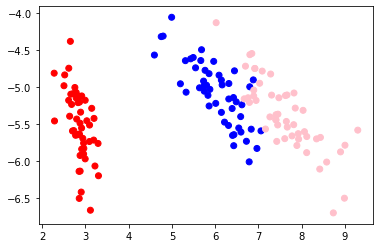

Retained variance for iris dataset  0.9776852063187947


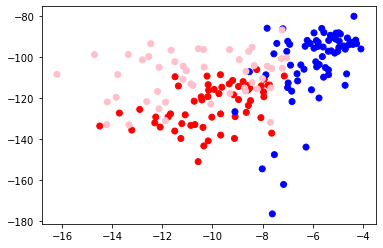

Retained variance for wine dataset  0.9998271461166033


In [183]:
#Use PCA for visualization of iris and wine data
data_iris=load_iris(return_X_y=True)
X=data_iris[0]
y=data_iris[1]
retained_variance_for_iris=visualize(X,y)
print("Retained variance for iris dataset ",retained_variance_for_iris)


data_wine=load_wine(return_X_y=True)
X=data_wine[0]
y=data_wine[1]
retained_variance_for_wine=visualize(X,y)
print("Retained variance for wine dataset ",retained_variance_for_wine)

Now you will use PCA on an actual real-world dataset. Implement feature reduction on the dataset using PCA with 99% retained variance. Use it to obtain the reduced features. On the reduced dataset, use linear regression and calculate the rmse values on test data. Your are encouraged to experiment with hyperparameters like the learning rate, number of epochs and regularization strength. Compare these results with those obtained by implementing regression on the unreduced dataset.  

In [108]:
#apply PCA on the dataset and also find the number of linearly independent and intrinsic components 
def apply_PCA_on_data(X):
    """
    Args:
    X: NxD numpy array, where N is number 
          of instances and D is the dimensionality of each 
          instance
    Return:
    X_pca: pca reduced dataset
    independent_features: number of independent features 
    intrinsic_dimensions: number of intrinsic dimensions
    """
    #center data
    X_c = X-X.mean()
    #to 2 features
    U,S,V = pca(X_c)
    independent_features = num_linearly_ind_features(pca(X_c)[1])
    intrinsic_dim = intrinsic_dimension(pca(X_c)[1])       
    X_pca = np.matmul(X, V[:, :intrinsic_dim])
    return X_pca, independent_features, intrinsic_dim

  

In [109]:
def apply_regression(X_train,y_train,X_test):
    """
    Args:
    X_train: training data without labels
    y_train: training labels
    X_test: test data 

    Return:
    y_pred: predicted labels
    """
    ###Apply Ridge regression fit SGD
      
    N,D = X_train.shape
    weight = np.zeros((D,1))
    epochs=1000
    learning_rate=1e-10
    c_lambda = 1600
    EPOCH = []
    MSE = []

    for epoch in range(epochs):
        EPOCH.append(epoch)
        pred = LinearReg.predict(X_train, weight)
        loss = y_train - pred
        mse = np.mean((pred - y_train) ** 2)
        MSE.append(mse)
        regul = c_lambda*weight/N
        gradient = np.dot(X_train.T,loss)/N+regul
        weight += learning_rate * gradient
            
    plt.plot(EPOCH,MSE)
    plt.xlabel('epochs')
    plt.ylabel('MSE')
    #weight = RidgeReg.fit_GD(X_train,y_train, 1600, epochs=1000, learning_rate=1e-10)
    y_pred = RidgeReg.predict(X_test, weight)
    return y_pred

data shape with PCA  (1460, 3)
Number of independent features  33
Number of intrinsic components  3
rmse score with PCA 96263.33429080147


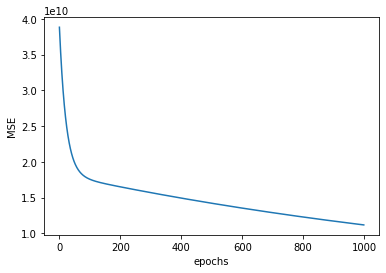

In [110]:
#load the dataset 
data=np.load("data.npy",allow_pickle=True)
X=data[:,:-1]
y=data[:,-1]
X_PCA, ind_features, intrinsic_dimensions = apply_PCA_on_data(X)
print("data shape with PCA ",X_PCA.shape)
print("Number of independent features ",ind_features)
print("Number of intrinsic components ",intrinsic_dimensions)

#get training and testing data 
X_train=X_PCA[:int(0.8*len(data)),:]
y_train=y[:int(0.8*len(data))].reshape(-1,1)
X_test=X_PCA[int(0.8*len(data)):]
y_test=y[int(0.8*len(data)):].reshape(-1,1)

#use Ridge Regression for getting predcited labels
y_pred=apply_regression(X_train,y_train,X_test)

#calculate RMSE 
rmse_score = rmse(y_pred, y_test)
print("rmse score with PCA",rmse_score)

rmse score without PCA 77847.25641615565


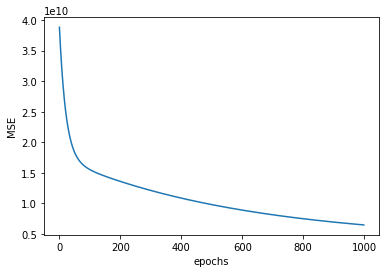

In [111]:
#Ridge regression without PCA
X_train=X[:int(0.8*len(data)),:]
y_train=y[:int(0.8*len(data))].reshape(-1,1)
X_test=X[int(0.8*len(data)):]
y_test=y[int(0.8*len(data)):].reshape(-1,1)

#use Ridge Regression for getting predcited labels
y_pred=apply_regression(X_train,y_train,X_test)

#calculate RMSE 
rmse_score = rmse(y_pred, y_test)
print("rmse score without PCA",rmse_score)

**Feature Scaling**

Principal component analysis is not agnostic to the scale of your features.  Measuring a feature with different units can change your principal components.

For this problem, randomly choose one column in each of the above datasets and multiply it by 1000.  For each of the datasets, answer the following:
1. How does this change the distribution of variance among the first 10 components?  
2. How does this change the first principal component of the data?
3. How does this affect the number of linearly independent components and intrinsic dimensionality?  Why?

It may be helpful to plot the variance captured by each component in a scree plot (see function below) and to make a bar plot of the absolute value of each feature in the first principal component.  

Original data


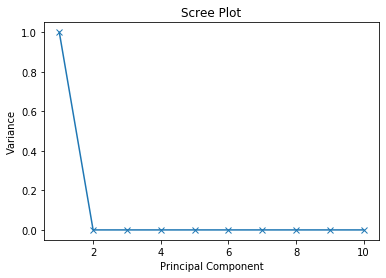

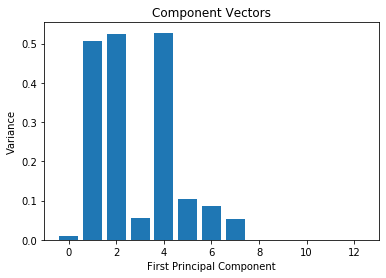

Perturbed data


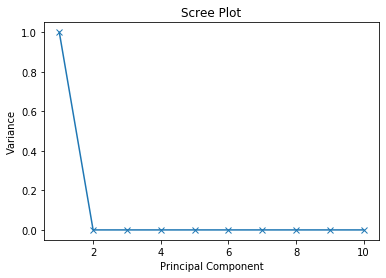

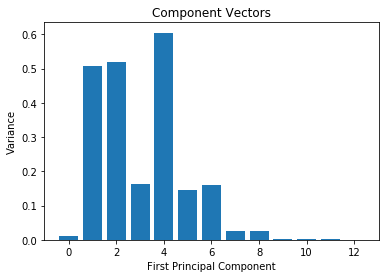

Linearly Independent Features (no pertubation):
8
Linearly Independent Features (with pertubation):
8
Intrinsic Dimensionality (no pertubation):
1
Intrinsic Dimensionality (with pertubation):
1


In [168]:
def randomly_perturb_data(data, multiplier=1000):
    """
    Multiply a random column in data by multiplier
    
    Inputs:
        data: N*D numpy array of features
        multiplier: multiplier by which to perturb a random column in data
        
    Returns:
        perturbed_data: Data with random column multiplied by multiplier
    """
    d = np.random.randint(low=0, high=data.shape[1])
    data[d] *= multiplier

    return data
   
    
def scree_plot(S, n_components=10):
    """
    Plot proportion of variance contained in each individual component
    """
    
    comp = []
    for i in range (1,n_components+1):
        comp.append(i)
    
    plt.plot(comp, np.power(S[:n_components],2)/np.sum(np.power(S,2)), 'x-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance')
    plt.show()
    
def plot_component_vector(V):
  
    vec = []
    for i in range (V.shape[0]):
        vec.append(i)

    plt.bar(vec,np.abs(V[0,:]))
    plt.title('Component Vectors')
    plt.xlabel('First Principal Component')
    plt.ylabel('Variance')
    plt.show()

print("Original data")    
scree_plot(pca(X)[1])
plot_component_vector(pca(X)[2])


print("Perturbed data")
X_pert = randomly_perturb_data(X)
scree_plot(pca(X_pert)[1])
plot_component_vector(pca(X_pert)[2])

print("Linearly Independent Features (no pertubation):")
print(num_linearly_ind_features(pca(X)[1]))

print("Linearly Independent Features (with pertubation):")
print(num_linearly_ind_features(pca(X_pert)[1]))

print("Intrinsic Dimensionality (no pertubation):")
print(intrinsic_dimension(pca(X)[1]))

print("Intrinsic Dimensionality (with pertubation):")
print(intrinsic_dimension(pca(X_pert)[1]))



### Write your analysis here
1. How does this change the distribution of variance among the first 10 components? <br>
The variance with/without pertubation stays the same.
2. How does this change the first principal component of the data?<br>
Does not chage.
3. How does this affect the number of linearly independent components and intrinsic dimensionality?  Why? <br>
Linearly independent features and intrinsic dimensionality do not change. Because the only principal component in both scenearios have the biggest variance.


## 5 Degree of Freedom [20pts] (Bonus for all)

(This question is challenging. Make sure you finish the rest of the assignment before you work on it.)

Given data $y_i$ with mean $f(x_i)$ and variance $\sigma^2$, and a fiitting operation $y \rightarrow \hat{y}$, where $y = [y_1, \dots , y_n]^T$ , $\hat{y} = [\hat{y}_1,\dots, \hat{y}_n ]^T$ , i.e., $y$ is the response value in the data, and $\hat{y}$ is estimated response value computed by a fitting algorithm such as linear least squares or regression tree algorithms. Let us define the degrees of freedom of a fit by

$$\sum_{i=1}^n\frac{\text{Cov}(y_i,\hat{y}_i)}{\sigma^2}$$

Consider a fit $\hat{y}$ estimated by a regression tree, fit to a set of predictors $X_1, \dots, X_p$

5.1. In terms of the number of terminal nodes $m$, give a rough formula for the degrees of freedom of the fit. (You may want to first consider the two extreme cases when $m = n$ and $m = 1$.)

5.2. Generate 100 observations with predictors $X_1, . . . , X_{100}$ as independent standard Gaussian variates and fix these values.

5.3. Generate response values also as standard Gaussian $(σ^2 = 1)$, independent of the predictors. Fit regression trees to the data of fixed size 1, 5 and 10 terminal nodes and hence estimate the degrees of freedom of each fit. (Do ten simulations of the response and average the results, to get a good estimate of degrees of freedom.)

5.4. Compare your estimates of degrees of freedom in (a) and (c) and discuss.

5.5. If the regression tree fit were a linear operation, we could write $\hat{y} = Sy$ for some matrix $S$ (recall linear least squares fit). Show that the degrees of freedom is given by $\text{Trace}(S)$. Suggest a way to compute an approximate $S$ matrix for a regression tree, compute it and compare the resulting degrees of freedom to those in (a) and (c).



In [4]:
## 5.2

X = np.empty([100, 10])
for i in range(10):
    X[:,i] = np.random.normal(0, 1, 100)

In [26]:

from sklearn.tree import DecisionTreeRegressor

def dof_estimation(X, m):
    N,D = X.shape
    dof = 0
    y = np.random.normal(0, 1, [100, 1])
    if m is 1:
        y_hat = np.ones(np.shape(y))*np.mean(y)
        cov = np.cov(y_hat.flatten(), y.flatten())
        #print(cov)
        #stands for the variance if X
        dof = np.trace(cov)
    else: #m=n
        for n in range(N):
            m = np.random.randint(N, size=(1000))
            X1 = X[m]
            y1 = y[m]
            regr = DecisionTreeRegressor(max_leaf_nodes = m)
            regr.fit(X1, y1)
            y_hat = regr.predict(X1)
            cov = np.mean((y_hat - np.mean(y_hat)) * (y1 - np.mean(y1)))
            dof += cov
    return dof

dof_estimation(X, 1)

#Do ten simulations when m=1
dof = []
for i in range(10):
    dof.append(dof_estimation(X, 1))
print("m=1:",np.mean(dof))

#Do ten simulations when m=n
N,D = X.shape
dof = []
for i in range(10):
    dof.append(dof_estimation(X, N))
print("m=n:",np.mean(dof))

[[ 7.78153513e-34 -7.78153513e-34]
 [-7.78153513e-34  1.05555050e+00]]
[[ 7.78153513e-34 -1.40067632e-33]
 [-1.40067632e-33  1.00964101e+00]]
[[1.94538378e-34 6.38085881e-34]
 [6.38085881e-34 1.00340668e+00]]
[[0.        0.       ]
 [0.        0.9274814]]
[[ 4.86345946e-35 -1.71193773e-34]
 [-1.71193773e-34  1.07275039e+00]]
[[ 3.03966216e-36 -1.16723027e-35]
 [-1.16723027e-35  9.25213837e-01]]
[[1.21586486e-35 1.14291297e-35]
 [1.14291297e-35 7.65505741e-01]]
[[7.78153513e-34 1.49405474e-33]
 [1.49405474e-33 8.82606187e-01]]
[[7.78153513e-34 1.33842404e-33]
 [1.33842404e-33 1.04566997e+00]]
[[1.21586486e-35 2.33446054e-35]
 [2.33446054e-35 1.13405338e+00]]
[[0.         0.        ]
 [0.         0.92505281]]
m=1: 0.9691381417191179


ValueError: max_leaf_nodes must be integral number but was array([ 8, 33, 48, 43, 77, 45, 65, 92, 68, 86, 47,  8, 75, 19,  6, 68, 76,
       75, 39, 97, 72, 16, 77, 18, 21, 65, 67, 23, 22, 54, 88, 23, 80, 63,
       77, 49, 37, 87, 78, 44, 50,  0, 91, 52, 26, 43, 32, 53, 48, 41, 83,
       87,  3, 95, 89, 70, 36, 28, 61, 36, 73, 64, 84,  8, 98, 75,  5, 93,
       80,  9, 56, 50, 95, 53,  5, 84, 10, 64, 17, 89,  9, 39, 85,  0, 60,
       81, 29, 36, 77, 50,  7, 58, 74, 59, 29, 31, 72, 38, 13, 31, 17, 87,
       28, 69, 19, 66, 50, 76, 25, 50, 87,  8, 85, 62,  4, 19, 28, 97, 56,
       69, 29, 45, 89, 24, 42, 19, 48, 51, 23, 56, 40, 84, 45,  5,  4, 32,
       50, 69, 97, 23, 68, 96, 86, 34, 97, 54, 33, 21, 70, 51, 64, 26, 58,
        8,  8, 14, 57, 43, 34, 56, 66, 62, 96, 49, 15, 82, 67, 34, 52,  9,
        0, 36,  3, 27, 60, 12,  2, 25, 37, 49, 28, 90,  5, 18,  0, 25,  3,
       66, 21, 17, 15, 83, 56, 81, 13, 33, 87, 53,  9, 58, 47, 40, 41, 45,
       43, 33, 27, 75, 42, 80, 45, 78, 12, 52, 38, 71, 19,  3, 72, 63, 31,
       43, 32, 93, 72,  5, 73, 15, 68, 30, 66, 25,  6, 61, 45, 54, 24, 44,
       37, 54, 76, 31, 81, 70, 23, 86, 15, 43, 30,  0, 39, 55, 42, 99, 83,
       53, 72, 82, 12, 11, 28, 94, 64, 93, 20, 12, 47, 70, 21, 41, 43, 70,
        6, 26, 10, 12,  0, 73, 94, 57, 14, 40, 22, 90, 84, 77, 29, 60, 85,
        0, 30,  5, 81, 75,  2, 39, 11, 69,  8, 10, 30, 38, 51, 46, 38, 39,
       42, 86, 26, 14, 29,  8, 35, 95, 52, 67, 48, 71, 67, 94, 67, 58,  5,
       96, 63, 56, 52,  0, 35, 34, 30, 13,  5,  3, 63, 74, 28, 94, 12, 78,
       43, 10, 96, 90, 39, 83, 47, 51, 85, 96, 50, 82, 22, 23, 62, 20, 49,
       33,  8, 30, 50, 74, 13, 41, 14, 63,  2, 99, 14,  7, 76, 14, 80, 94,
       73, 86, 25, 97, 49, 72, 43, 65, 18, 74, 39, 68,  8, 93, 49, 45, 42,
       50,  4, 18, 77, 50, 40, 79, 39, 31, 24, 41, 50,  3, 50, 87, 77, 38,
       75, 72, 10, 76, 17, 25, 62, 42, 75, 80,  3, 18, 22,  8, 72, 63, 25,
       85, 29, 36, 12, 41, 22,  4, 18, 65,  3, 13, 97,  6, 23, 31, 70, 79,
       48, 91, 28, 94, 86, 41, 31, 68, 72, 97, 54, 65, 32,  5, 95, 24, 52,
        2, 69, 67, 19, 79, 89, 91, 83, 82, 28, 31, 68, 44, 29, 33, 60, 58,
       89, 34, 93, 29, 22, 51, 30, 57, 80, 23, 33, 90, 15, 49, 31, 60, 83,
       59, 39, 81, 94, 44, 38, 22, 72, 42, 39, 54, 70, 41, 79, 42, 49, 21,
       63, 72, 37, 35, 93, 27, 75, 24, 54, 45, 40, 14, 19, 49, 96, 22, 39,
       65, 57, 15, 28, 76, 76, 35, 17, 67, 73, 86, 54, 64, 51, 98, 67, 18,
       29, 22, 63, 55, 96, 71, 61, 11, 60, 89, 67, 86, 86, 41, 29,  9, 48,
       14, 78, 80, 29,  5, 41, 18, 49, 19,  3, 33, 73, 87, 29, 69, 97, 28,
       70, 49, 15, 51, 19, 24, 70, 92, 59,  7, 27,  8, 27, 65, 73, 50, 21,
       28, 84, 46, 93, 85, 63, 70, 93, 88, 25, 86, 24, 38, 75, 92, 51, 94,
        8, 13, 65, 15,  8, 94, 69, 40, 21, 12, 15, 15,  0, 36, 58, 82, 19,
       74, 76, 40, 87, 71, 10, 25, 76,  4, 89, 78, 27, 79, 51, 86, 15, 56,
       17, 87, 50, 24, 47, 82, 64, 65,  1, 53, 54, 59, 94, 44, 58, 36, 28,
       98, 69, 55, 17, 38, 20, 72, 43, 37, 47, 55, 97, 85, 47,  8, 49, 47,
       14, 60, 54, 77, 61, 52, 60, 38, 67, 66, 53, 50, 43, 28, 80, 45, 26,
       99, 13, 99, 23,  1, 19,  2, 92, 13, 19, 76, 38, 25, 39, 83, 11, 78,
       46, 77, 51, 14, 31, 69, 86, 94, 72, 24, 52, 18, 62, 50, 73,  5, 40,
       94,  1, 38, 41, 99, 45, 36, 49, 44, 90, 27, 90, 15,  9, 71, 93, 80,
       44, 35, 49, 34, 22, 86, 83,  4, 54, 71, 82,  1,  5, 84, 61, 15, 37,
       27, 74, 43,  4, 57, 96, 42, 69,  2,  4,  5, 47, 55, 38, 96, 19, 11,
       84, 48, 18, 45, 77, 90, 21, 37, 47, 23, 54, 13, 19, 32, 66, 34, 87,
       39, 26, 55, 17, 93, 57,  6, 68, 76, 84, 39, 59, 84, 82, 35, 77,  7,
       17, 65, 49, 18, 60,  0, 17,  7, 20, 26, 88,  6, 98, 70,  5, 95, 20,
       44, 73, 64,  7, 56, 98, 64, 24, 17, 63, 26,  6, 74, 46, 69, 86, 12,
       40, 12, 64, 98, 74, 77, 25, 66, 70, 69, 76, 97, 59, 44, 34, 54, 34,
       94, 12, 65,  6, 77, 58, 67, 44, 86, 94, 82, 93, 10,  6, 16, 11, 32,
       59, 86, 78, 47, 16, 68,  3,  8, 71, 88, 67, 87,  6, 49, 52, 18, 95,
       83, 63, 83, 51, 85,  7, 34, 50, 88, 53,  5, 33,  6, 67, 36, 94, 58,
        5, 92, 15, 21, 83, 12, 85, 92, 78, 40, 49,  7, 53, 77, 50, 50, 74,
       79, 13, 39, 35,  1, 65, 48, 12, 94, 49, 24, 78, 74, 63, 60,  6, 28,
        2, 13, 47, 38, 82, 63, 44, 42, 26, 27, 21,  6, 94, 66, 41, 69, 73,
       95, 36, 27, 39, 40,  9, 71, 30, 51,  7, 17, 80, 94, 64, 52, 72, 49,
       49, 71, 74, 87, 77,  9, 62, 94, 74, 69, 20, 14, 67, 66])